# Chapter 8 - Comparing Gaussian means

In [1]:
using Pkg
using Logging
using DynamicPPL, Turing
using Zygote, ReverseDiff
using StatsPlots, Random
using LaTeXStrings
using CSV
using DataFrames
using SpecialFunctions
using LinearAlgebra
using FillArrays
using CSV, DataFrames
using LogExpFunctions
using KernelDensity

In [2]:
format=:png

:png

In [3]:
Random.seed!(6)

TaskLocalRNG()

## 8.1 One-sample comparison
$$ \delta \sim \text{Cauchy} (0, 1)$$
$$ \sigma \sim \text{Cauchy} (0, 1)_{\mathcal I(0,∞)}$$
$$ \mu = \delta\sigma $$
$$ x_{i} \sim \text{Gaussian}(\mu,1/\sigma^2)$$

In [4]:
winter = [
    -0.05, 0.41, 0.17, -0.13, 0.00, -0.05, 0.00, 0.17, 0.29, 0.04, 0.21, 0.08, 0.37,
    0.17, 0.08, -0.04, -0.04, 0.04, -0.13, -0.12, 0.04, 0.21, 0.17, 0.17, 0.17,
    0.33, 0.04, 0.04, 0.04, 0.00, 0.21, 0.13, 0.25, -0.05, 0.29, 0.42, -0.05, 0.12,
    0.04, 0.25, 0.12
]

summer = [
    0.00, 0.38, -0.12, 0.12, 0.25, 0.12, 0.13, 0.37, 0.00, 0.50, 0.00, 0.00, -0.13,
    -0.37, -0.25, -0.12, 0.50, 0.25, 0.13, 0.25, 0.25, 0.38, 0.25, 0.12, 0.00, 0.00,
    0.00, 0.00, 0.25, 0.13, -0.25, -0.38, -0.13, -0.25, 0.00, 0.00, -0.12, 0.25,
    0.00, 0.50, 0.00
]
x = winter - summer  # allowed because it is a within-subjects design
x = x / std(x);

In [5]:
@model function OneSampleComparison(x)
    delta ~ Cauchy(0,1)
    sigma ~ truncated(Cauchy(0,1), lower=0)

    mu = delta * sigma
    
    for i in eachindex(x)
        x[i] ~ Normal(mu, sigma)
    end
end

iterations=5_000
burnin=2500

model_one_sample_comparison = OneSampleComparison(x)
chain = sample(model_one_sample_comparison, NUTS(), iterations, burnin=burnin)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 8.43 seconds
Compute duration  = 8.43 seconds
parameters        = delta, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       delta    0.1199    0.1508    0.0021   5048.5898   3389.8513    1.0000   ⋯
       sigma    1.0069    0.1123    0.0016   5440.4428   3822.7463    1.0000   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

  

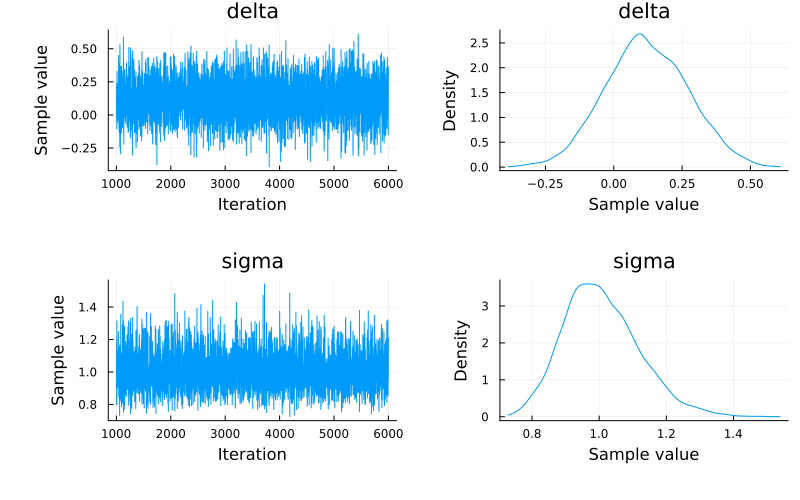

In [6]:
plot(chain, size=(800, 500),
    left_margin=10Plots.mm, bottom_margin=10Plots.mm, fmt=format)

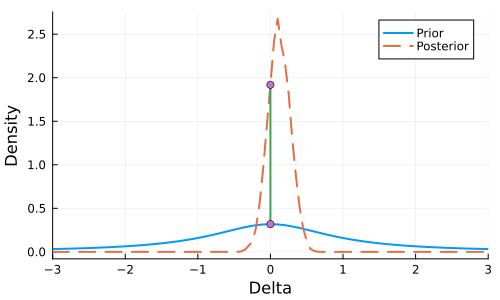

In [7]:
plot(-3:0.1:3, [pdf(Cauchy(0, 1), e) for e in -3:0.1:3], 
    size=(500,300), fmt=format, linewidth=2, label="Prior")
k = kde(chain[:delta] |> vec)
plot!(-3:0.05:3, pdf(k, -3:0.05:3), linewidth=2, ls=:dash, label="Posterior")

plot!([0, 0], [pdf(Cauchy(0, 1), 0), pdf(k, 0)], linewidth=2, label=false)
scatter!([0, 0], [pdf(Cauchy(0, 1), 0), pdf(k, 0)], label=false)

xlabel!("Delta")
ylabel!("Density")
xlims!(-3, 3)

In [8]:
bayes_factor_1 = pdf(k, 0) / pdf(Cauchy(0, 1), 0)

6.028442134709729

## 8.2 Order-restricted one-sample comparison


$$ \delta \sim \text{Cauchy} (0, 1)_{\mathcal I(-∞,0)}$$
$$ \sigma \sim \text{Cauchy} (0, 1)_{\mathcal I(0,∞)}$$
$$ \mu = \delta\sigma $$
$$ x_{i} \sim \text{Gaussian}(\mu,1/\sigma^2)$$

In [9]:
winter = [
    -0.05, 0.41, 0.17, -0.13, 0.00, -0.05, 0.00, 0.17, 0.29, 0.04, 0.21, 0.08, 0.37,
    0.17, 0.08, -0.04, -0.04, 0.04, -0.13, -0.12, 0.04, 0.21, 0.17, 0.17, 0.17,
    0.33, 0.04, 0.04, 0.04, 0.00, 0.21, 0.13, 0.25, -0.05, 0.29, 0.42, -0.05, 0.12,
    0.04, 0.25, 0.12
]

summer = [
    0.00, 0.38, -0.12, 0.12, 0.25, 0.12, 0.13, 0.37, 0.00, 0.50, 0.00, 0.00, -0.13,
    -0.37, -0.25, -0.12, 0.50, 0.25, 0.13, 0.25, 0.25, 0.38, 0.25, 0.12, 0.00, 0.00,
    0.00, 0.00, 0.25, 0.13, -0.25, -0.38, -0.13, -0.25, 0.00, 0.00, -0.12, 0.25,
    0.00, 0.50, 0.00
]
x = winter - summer
x = x / std(x);

In [10]:
@model function OrderRestrictedOneSampleComparison(x)
    delta ~ truncated(Cauchy(0, 1), upper=0)
    sigma ~ truncated(Cauchy(0, 1), lower=0)

    mu = delta * sigma

    for i in eachindex(x)
        x[i] ~ Normal(mu, sigma)
    end
end

iterations = 5_000
burnin = 2500

model_order_restricted_one_sample_comparison = OrderRestrictedOneSampleComparison(x)
chain = sample(model_order_restricted_one_sample_comparison, NUTS(), iterations, burnin=burnin)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 2.7 seconds
Compute duration  = 2.7 seconds
parameters        = delta, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       delta   -0.0882    0.0724    0.0016   1910.6339   1633.7101    1.0010   ⋯
       sigma    1.0177    0.1144    0.0022   2863.8006   2769.0360    0.9998   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

    

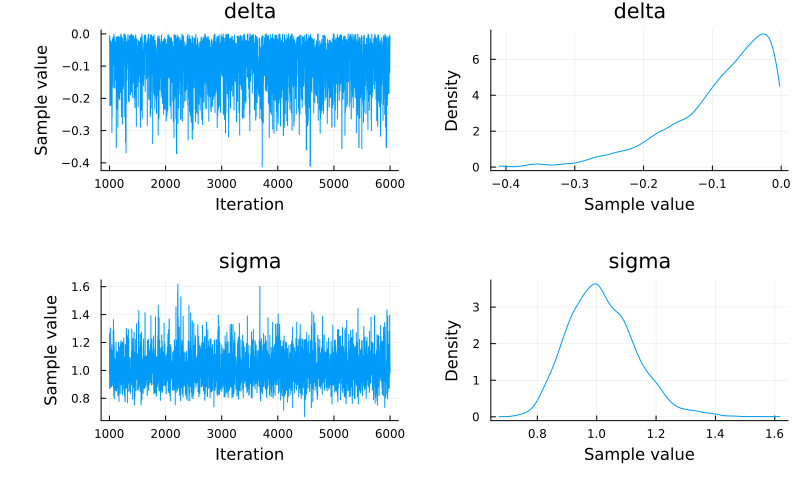

In [11]:
plot(chain, size=(800, 500),
    left_margin=10Plots.mm, bottom_margin=10Plots.mm, fmt=format)

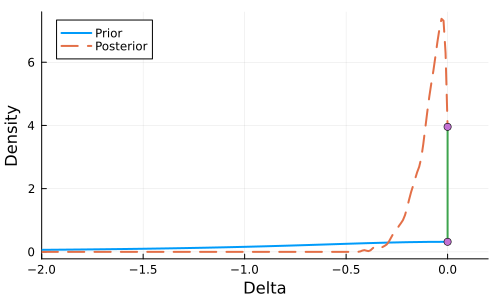

In [12]:
plot(-3:0.1:0, [pdf(Cauchy(0, 1), e) for e in -3:0.1:0], 
    size=(500,300), fmt=format, linewidth=2, label="Prior")

k = kde(chain[:delta] |> vec)
plot!(-3:0.01:0, pdf(k, -3:0.01:0), linewidth=2, ls=:dash, label="Posterior")

plot!([0, 0], [pdf(Cauchy(0, 1), 0), pdf(k, 0)], linewidth=2, label=false)
scatter!([0, 0], [pdf(Cauchy(0, 1), 0), pdf(k, 0)], label=false)

xlabel!("Delta")
ylabel!("Density")
xlims!(-2, 0.2)

In [13]:
bayes_factor_2 = pdf(k, 0) / pdf(Cauchy(0, 1), 0)

12.430334525019

## 8.3 Two-sample comparison


$$ \delta \sim \text{Cauchy} (0, 1)$$
$$ \mu \sim \text{Cauchy} (0, 1)$$
$$ \sigma \sim \text{Cauchy} (0, 1)_{\mathcal I(0,∞)}$$
$$ \alpha = \delta\sigma $$
$$ x_{i} \sim \text{Gaussian}(\mu+\frac{\alpha}{2},1/\sigma^2)$$
$$ y_{i} \sim \text{Gaussian}(\mu-\frac{\alpha}{2},1/\sigma^2)$$


In [14]:
x = [70, 80, 79, 83, 77, 75, 84, 78, 75, 75, 78, 82, 74, 81, 72, 70, 75, 72, 76, 77]
y = [56, 80, 63, 62, 67, 71, 68, 76, 79, 67, 76, 74, 67, 70, 62, 65, 72, 72, 69, 71]

n1 = length(x)
n2 = length(y)

y = y .- mean(x)
y = y ./ std(x)
x = (x .- mean(x)) ./ std(x);

In [15]:
@model function TwoSampleComparison(x, y)
    delta ~ Cauchy(0, 1)
    mu ~ Cauchy(0, 1)
    sigma ~ truncated(Cauchy(0, 1), lower=0)
    alpha = delta * sigma
    
    for i in eachindex(x)
        x[i] ~ Normal(mu + alpha / 2., sigma)
        y[i] ~ Normal(mu - alpha / 2., sigma)
    end
end

iterations = 5_000
burnin = 2500

model_two_sample_comparison = TwoSampleComparison(x, y)
chain = sample(model_two_sample_comparison, NUTS(), iterations, burnin=burnin)

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 3.55 seconds
Compute duration  = 3.55 seconds
parameters        = delta, mu, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       delta    1.3101    0.3555    0.0050   4974.9642   2996.4651    1.0002   ⋯
          mu   -0.8608    0.2047    0.0026   6454.6084   3856.2363    1.0000   ⋯
       sigma    1.3021    0.1505    0.0022   4500.3307   3901.1558    0.9999   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%    

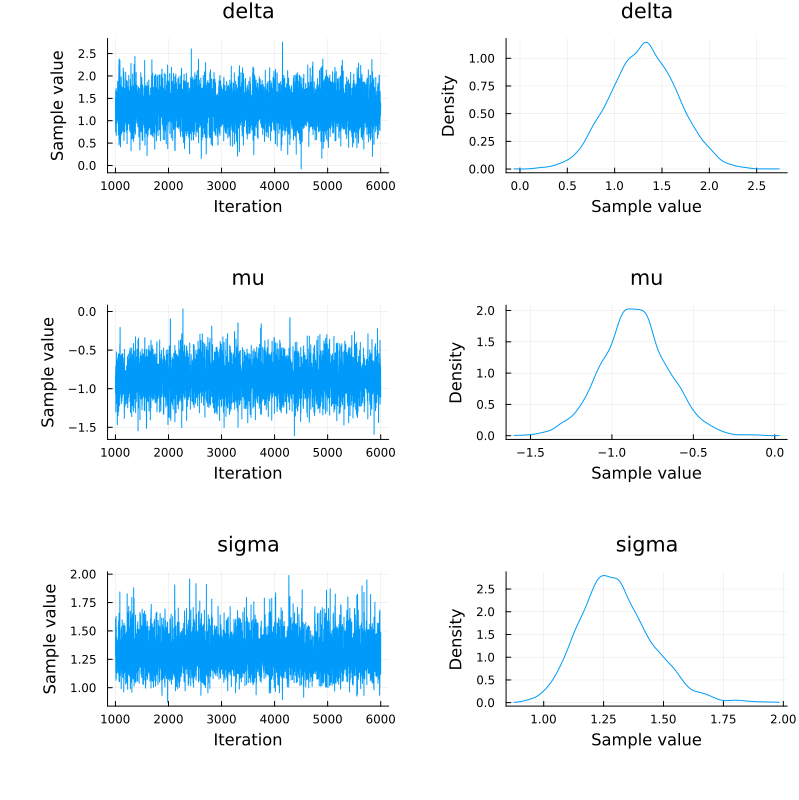

In [16]:
plot(chain, size=(800,800), left_margin=10Plots.mm, bottom_margin=10Plots.mm, fmt=format)

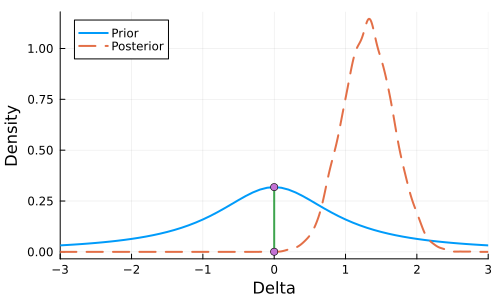

In [17]:
plot(-3:0.1:3, [pdf(Cauchy(0, 1), e) for e in -3:0.1:3], 
    size=(500,300), fmt=format, linewidth=2, label="Prior")

k = kde(chain[:delta] |> vec)
plot!(-3:0.01:3, pdf(k, -3:0.01:3), linewidth=2, ls=:dash, label="Posterior")

plot!([0, 0], [pdf(Cauchy(0, 1), 0), pdf(k, 0)], linewidth=2, label=false)
scatter!([0, 0], [pdf(Cauchy(0, 1), 0), pdf(k, 0)], label=false)

xlabel!("Delta")
ylabel!("Density")
xlims!(-3, 3)

In [18]:
bayes_factor_3 = pdf(Cauchy(0, 1), 0) / pdf(k, 0)

503.9036133433892

In [19]:
Pkg.status()

Status `~/quangtiencs_projects/bayesian-cognitive-modeling-with-turing.jl/Project.toml`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
⌃ [366bfd00] DynamicPPL v0.23.0
  [7073ff75] IJulia v1.24.2
  [5ab0869b] KernelDensity v0.6.7
  [b964fa9f] LaTeXStrings v1.3.0
  [2ab3a3ac] LogExpFunctions v0.3.24
  [91a5bcdd] Plots v1.38.17
  [37e2e3b7] ReverseDiff v1.15.0
  [276daf66] SpecialFunctions v2.3.0
  [f3b207a7] StatsPlots v0.15.6
  [fce5fe82] Turing v0.28.1
  [e88e6eb3] Zygote v0.6.62
Info Packages marked with ⌃ have new versions available and may be upgradable.
